The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# Kaggle 上的狗品种识别（iMagenNet 狗）

在本节中，我们将在 Kaggle 上练习狗品种识别问题。本次比赛的网址是 https://www.kaggle.com/c/dog-breed-identification 

在这场比赛中，120 种不同品种的狗将被认可。事实上，本次比赛的数据集是 iMagenet 数据集的子集。与 :numref:`sec_kaggle_cifar10` 中 CIFAR-10 数据集中的图像不同，iMagenet 数据集中的图像在不同维度上既更高也更宽。:numref:`fig_kaggle_dog` 显示了竞争对手网页上的信息。您需要一个 Kaggle 账户才能提交结果。 

![The dog breed identification competition website. The competition dataset can be obtained by clicking the "Data" tab.](../img/kaggle-dog.jpg)
:width:`400px`
:label:`fig_kaggle_dog`


In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## 获取和组织数据集

比赛数据集分为训练集和测试集，其中分别包含三个 RGB（彩色）通道的 10222 和 10357 张 JPEG 图像。在训练数据集中，有 120 种犬类，如拉布拉多犬、贵宾犬、腊肠犬、萨摩耶德、哈士奇、奇娃娃和约克郡梗。 

### 下载数据集

登录 Kaggle 后，您可以点击 :numref:`fig_kaggle_dog` 中显示的竞争网页上的 “数据” 选项卡，然后点击 “全部下载” 按钮下载数据集。在 `../data` 中解压下载的文件后，您将在以下路径中找到整个数据集： 

* ../data/dog-breed-identification/labels.csv
* ../data/dog-breed-identification/sample_submission.csv
* ../数据/种身份识别/火车
* ../数据/种身份识别/测试

你可能已经注意到，上述结构与 :numref:`sec_kaggle_cifar10` 的 CIFAR-10 竞争对手类似，其中文件夹 `train/` 和 `test/` 分别包含训练和测试狗图像，`labels.csv` 包含训练图像的标签。同样，为了便于入门，我们提供了上面提到的数据集的一小部分示例：`train_valid_test_tiny.zip`。如果您要在 Kaggle 比赛中使用完整的数据集，则需要将下面的 `demo` 变量更改为 `False`。


In [2]:
#@save
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to `False`
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

### 组织数据集

我们可以像 :numref:`sec_kaggle_cifar10` 中所做的那样组织数据集，即从原始训练集中拆分验证集，然后将图像移动到按标签分组的子文件夹中。 

下面的 `reorg_dog_data` 函数读取训练数据标签、拆分验证集并组织训练集。


In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## 图像增强

回想一下，这个狗品种数据集是 iMagenet 数据集的子集，其图像大于 :numref:`sec_kaggle_cifar10` 中 CIFAR-10 数据集的图像。下面列出了一些对于相对较大的图像可能有用的图像增强操作。


In [4]:
transform_train = torchvision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                       saturation=0.4),
    # Add random noise
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

在预测期间，我们只使用没有随机性的图像预处理操作。


In [5]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a 224 x 224 square area from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

## 阅读数据集

与 :numref:`sec_kaggle_cifar10` 一样，我们可以读取由原始图像文件组成的组织数据集。


In [6]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

下面我们创建数据加载器实例的方式与 :numref:`sec_kaggle_cifar10` 相同。


In [7]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## 微调预训练模型

同样，本次比赛的数据集是 iMagenet 数据集的子集。因此，我们可以使用 :numref:`sec_fine_tuning` 中讨论的方法在完整 iMagenet 数据集上选择预训练的模型，然后使用该模型提取图像要素，以便将其输入到定制的小规模输出网络中。深度学习框架的高级 API 提供了在 iMagenet 数据集上预训练的各种模型。在这里，我们选择预训练的 Resnet-34 模型，我们只需重复使用此模型的输出层（即提取的要素）的输入。然后，我们可以用一个可以训练的小型自定义输出网络替换原始输出层，例如堆叠两个完全连接的图层。与 :numref:`sec_fine_tuning` 中的实验不同，以下内容不重新训练用于特征提取的预训练模型。这减少了存储渐变的训练时间和内存。 

回想一下，我们使用三个 RGB 通道的均值和标准差来对完整的 iMagenet 数据集进行图像标准化。事实上，这也符合 iMagenet 上预训练模型的标准化操作。


In [8]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(),
                                            nn.Linear(256, 120))
    # Move the model to devices
    finetune_net = finetune_net.to(devices[0])
    # Freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

在计算损失之前，我们首先获取预训练模型的输出层的输入，即提取的要素。然后我们使用此功能作为小型自定义输出网络的输入来计算损失。


In [9]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum = l.sum()
        n += labels.numel()
    return l_sum / n

## 定义训练功能

我们将根据模型在验证集上的性能选择模型并调整超参数。模型训练功能 `train` 只迭代小型自定义输出网络的参数。


In [10]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD(
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'valid loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
        scheduler.step()
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f}, '
              f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

## 培训和验证模型

现在我们可以训练和验证模型了。以下超参数都是可调的。例如，可以增加纪元的数量。由于 `lr_period` 和 `lr_decay` 分别设置为 10 和 0.1，因此优化算法的学习速率将在每 10 个纪元后乘以 0.1。


train loss 3.690, valid loss 0.108
105.9 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


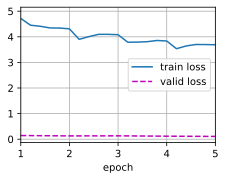

In [11]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.001, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## 在 Kaggle 上对测试集进行分类并提交结果

与 :numref:`sec_kaggle_cifar10` 中的最后一步类似，最终所有标记的数据（包括验证集）都用于训练模型和对测试集进行分类。我们将使用训练有素的自定义输出网络进行分类。


train loss 3.731
129.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


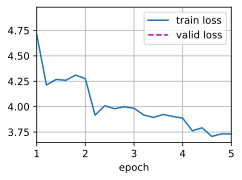

In [12]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(
    os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(
            i.split('.')[0] + ',' + ','.join([str(num)
                                              for num in output]) + '\n')

上面的代码将生成一个 `submission.csv` 文件，以 :numref:`sec_kaggle_house` 中描述的方式提交给 Kaggle。 

## 摘要

* iMagenet 数据集中的图像比 CIFAR-10 图像大（尺寸不同）。我们可能会修改不同数据集上任务的图像增强操作。 
* 要对 iMagenet 数据集的子集进行分类，我们可以利用完整 iMagenet 数据集上的预训练模型来提取要素并仅训练自定义的小规模输出网络。这将减少计算时间和内存成本。

## 练习

1. 使用填充 Kaggle 竞争数据集时，当您增加 `batch_size`（批量大小）和 `num_epochs`（时代数量）时，您能取得什么结果？
1. 如果你使用更深入的预训练模型，你会得到更好的结果吗？你如何调整超参数？你能进一步改善结果吗？


[Discussions](https://discuss.d2l.ai/t/1481)
